In [13]:
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, HalvingRandomSearchCV
from sklearn.metrics import accuracy_score,precision_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

In [14]:
df = pd.read_csv("../data/clean/merged.csv")
#df = pd.read_csv("../data/clean/teams.csv") # TESTING

# Convert "playoff" column to binary (Y: 1, N: 0)
df["playoff"] = df["playoff"].map({"Y": 1, "N": 0})
df.head()

,tmID,year,confID,playoff,last_year_rank,last_year_o_fga,last_year_o_fta,last_year_o_3pa,last_year_o_reb,last_year_o_asts,...,avg_team_last_year_allPF,avg_team_last_year_allFGA,avg_team_last_year_allTR,avg_team_last_year_allTRA,avg_team_last_year_allMinutes,num_players_joined,num_players_left,num_players_changed_team,award_points_coach,last_year_mean_wins_coach
0,ATL,9,EA,0.0,3.5,2079.8,640.9,502.7,1077.6,520.7,...,55.259615,166.201122,17.840144,49.144631,510.537660,14.0,9.0,23.0,0.0,1.026701
1,ATL,10,EA,1.0,7.0,2258.0,725.0,598.0,1077.0,492.0,...,54.361367,169.501920,17.682412,55.124040,526.865207,8.0,13.0,21.0,1.0,0.133333
2,ATL,11,EA,NaN,2.0,2428.0,755.0,374.0,1259.0,547.0,...,56.603550,203.643491,12.802515,41.376479,638.306213,0.0,0.0,0.0,0.0,1.000000
3,CHA,1,EA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,54.676768,178.505051,16.609091,49.047475,574.079798,13.0,8.0,21.0,0.0,0.000000
4,CHA,2,EA,1.0,8.0,1903.0,577.0,386.0,935.0,551.0,...,70.366267,198.638224,21.541417,62.973054,686.959581,7.0,3.0,10.0,0.0,0.391304


### Label Encoding

In [15]:
from sklearn.preprocessing import LabelEncoder

def encode_df(df):
    le = LabelEncoder()
    tmID_mapping = {} 
    
    for col, col_type in df.dtypes.items():
        if col_type == 'object' or col_type == 'datetime64[ns]':
            # store mapping if the column is 'tmID'
            if col == 'tmID':
                df[col] = le.fit_transform(df[col])
                tmID_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
            else:
                df[col] = le.fit_transform(df[col])
                
    return df, tmID_mapping

# Use the function to encode the dataframe and get the tmID mapping
df, tmID_mapping = encode_df(df)


df.head( 10)

,tmID,year,confID,playoff,last_year_rank,last_year_o_fga,last_year_o_fta,last_year_o_3pa,last_year_o_reb,last_year_o_asts,...,avg_team_last_year_allPF,avg_team_last_year_allFGA,avg_team_last_year_allTR,avg_team_last_year_allTRA,avg_team_last_year_allMinutes,num_players_joined,num_players_left,num_players_changed_team,award_points_coach,last_year_mean_wins_coach
0,0,9,0,0.0,3.5,2079.8,640.9,502.7,1077.6,520.7,...,55.259615,166.201122,17.840144,49.144631,510.537660,14.0,9.0,23.0,0.0,1.026701
1,0,10,0,1.0,7.0,2258.0,725.0,598.0,1077.0,492.0,...,54.361367,169.501920,17.682412,55.124040,526.865207,8.0,13.0,21.0,1.0,0.133333
2,0,11,0,NaN,2.0,2428.0,755.0,374.0,1259.0,547.0,...,56.603550,203.643491,12.802515,41.376479,638.306213,0.0,0.0,0.0,0.0,1.000000
3,1,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,54.676768,178.505051,16.609091,49.047475,574.079798,13.0,8.0,21.0,0.0,0.000000
4,1,2,0,1.0,8.0,1903.0,577.0,386.0,935.0,551.0,...,70.366267,198.638224,21.541417,62.973054,686.959581,7.0,3.0,10.0,0.0,0.391304
5,1,3,0,1.0,4.0,1780.0,528.0,428.0,948.0,467.0,...,52.101873,163.185019,14.962547,44.767041,556.393258,4.0,6.0,10.0,0.0,1.222222
6,1,4,0,1.0,2.0,1790.0,663.0,527.0,955.0,496.0,...,54.248485,161.560606,10.450000,29.219697,516.807576,4.0,4.0,8.0,0.0,1.124761
7,1,5,0,0.0,2.0,1881.0,590.0,517.0,971.0,499.0,...,53.480250,206.604046,17.827071,48.765414,616.022158,7.0,7.0,14.0,0.0,1.000000
8,1,6,0,0.0,5.0,1744.0,590.0,459.0,872.0,426.0,...,59.354549,220.876611,19.361187,55.106599,651.615775,9.0,9.0,18.0,0.0,1.190826
9,1,6,0,0.0,5.0,1744.0,590.0,459.0,872.0,426.0,...,59.354549,220.876611,19.361187,55.106599,651.615775,9.0,9.0,18.0,0.0,0.888889


In [16]:
def calculate_class_distribution_similarity(df, y_train, y_test):
    # Step 1: Calculate class distribution in the original dataset
    original_class_distribution = df['playoff'].value_counts(normalize=True)
    print("Original Class Distribution:")
    print(original_class_distribution)

    # Step 2: Calculate class distribution in the training and test sets
    train_class_distribution = y_train.value_counts(normalize=True)
    test_class_distribution = y_test.value_counts(normalize=True)

    print("\nTraining Set Class Distribution:")
    print(train_class_distribution)
    print("\nTest Set Class Distribution:")
    print(test_class_distribution)

    # Step 3: Compare class distributions
    class_distribution_similarity = (train_class_distribution - test_class_distribution).abs().sum()
    print("\nClass Distribution Similarity Score:", class_distribution_similarity)

    return class_distribution_similarity

# Update the train_model function to include imputation
def train_model(df, year, maximum_diff = 0):
    # Remove rows with missing values
    df.dropna(inplace=True)

    teams_df_train = None
    if (maximum_diff != 0):
        teams_df_train = df[(df['year'] < year) &  (df['year'] >= year - maximum_diff)]
    else:
        teams_df_train = df[df['year'] < year]
    teams_df_test = df[df['year'] == year]

    X_train = teams_df_train.drop("playoff", axis=1)  # Features
    y_train = teams_df_train["playoff"]  # Target variable

    X_test = teams_df_test.drop("playoff", axis=1)  # Features
    y_test = teams_df_test["playoff"]  # Target variable

    print(f"\nTrain/Test size for year={year}:", X_train.shape, X_test.shape, y_train.shape, y_test.shape)

    return X_train, y_train, X_test, y_test

# create a final dataset with the predictions: team, playoff, prediction (a probability between 0 and 1)
def create_predictions(df, year, model, maximum_diff = 0,distribution_similarity=True):
    # Create a copy of the original dataset
    new_df = df.copy()

    X_train, y_train, X_test, y_test = train_model(new_df, year,maximum_diff)

    # Check if the class distribution is similar between the training and test sets
    if distribution_similarity:
        calculate_class_distribution_similarity(new_df, y_train, y_test)    

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test) # Predictions
    y_pred_proba = model.predict_proba(X_test) # Prediction probabilities

    # Only add predictions to the test set
    new_df.loc[new_df['year'] == year, 'prediction'] = y_pred
    new_df.loc[new_df['year'] == year, 'prediction_proba'] = y_pred_proba[:,1]

    # Filter the dataset to only include the year we are interested in
    new_df = new_df[new_df['year'] == year]

    # Convert the predictions to integers
    new_df['prediction'] = new_df['prediction'].astype(int)

    return new_df


Training model: Logistic Regression

Train/Test size for year=2: (17, 60) (18, 60) (17,) (18,)

Train/Test size for year=3: (35, 60) (19, 60) (35,) (19,)

Train/Test size for year=4: (54, 60) (16, 60) (54,) (16,)

Train/Test size for year=5: (70, 60) (17, 60) (70,) (17,)

Train/Test size for year=6: (87, 60) (15, 60) (87,) (15,)


C:\Users\marco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Train/Test size for year=7: (102, 60) (15, 60) (102,) (15,)


C:\Users\marco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Train/Test size for year=8: (117, 60) (14, 60) (117,) (14,)


C:\Users\marco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Train/Test size for year=9: (131, 60) (15, 60) (131,) (15,)


C:\Users\marco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Train/Test size for year=10: (146, 60) (16, 60) (146,) (16,)


C:\Users\marco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Training model: Random Forest

Train/Test size for year=2: (17, 60) (18, 60) (17,) (18,)

Train/Test size for year=3: (35, 60) (19, 60) (35,) (19,)

Train/Test size for year=4: (54, 60) (16, 60) (54,) (16,)

Train/Test size for year=5: (70, 60) (17, 60) (70,) (17,)

Train/Test size for year=6: (87, 60) (15, 60) (87,) (15,)

Train/Test size for year=7: (102, 60) (15, 60) (102,) (15,)

Train/Test size for year=8: (117, 60) (14, 60) (117,) (14,)

Train/Test size for year=9: (131, 60) (15, 60) (131,) (15,)

Train/Test size for year=10: (146, 60) (16, 60) (146,) (16,)

Training model: Gradient Boosting

Train/Test size for year=2: (17, 60) (18, 60) (17,) (18,)

Train/Test size for year=3: (35, 60) (19, 60) (35,) (19,)

Train/Test size for year=4: (54, 60) (16, 60) (54,) (16,)

Train/Test size for year=5: (70, 60) (17, 60) (70,) (17,)

Train/Test size for year=6: (87, 60) (15, 60) (87,) (15,)

Train/Test size for year=7: (102, 60) (15, 60) (102,) (15,)

Train/Test size for year=8: (117, 60)

C:\Users\marco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\marco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\marco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no pred


Train/Test size for year=3: (35, 60) (19, 60) (35,) (19,)

Train/Test size for year=4: (54, 60) (16, 60) (54,) (16,)

Train/Test size for year=5: (70, 60) (17, 60) (70,) (17,)


C:\Users\marco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



Train/Test size for year=6: (87, 60) (15, 60) (87,) (15,)

Train/Test size for year=7: (102, 60) (15, 60) (102,) (15,)

Train/Test size for year=8: (117, 60) (14, 60) (117,) (14,)


C:\Users\marco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



Train/Test size for year=9: (131, 60) (15, 60) (131,) (15,)

Train/Test size for year=10: (146, 60) (16, 60) (146,) (16,)


C:\Users\marco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


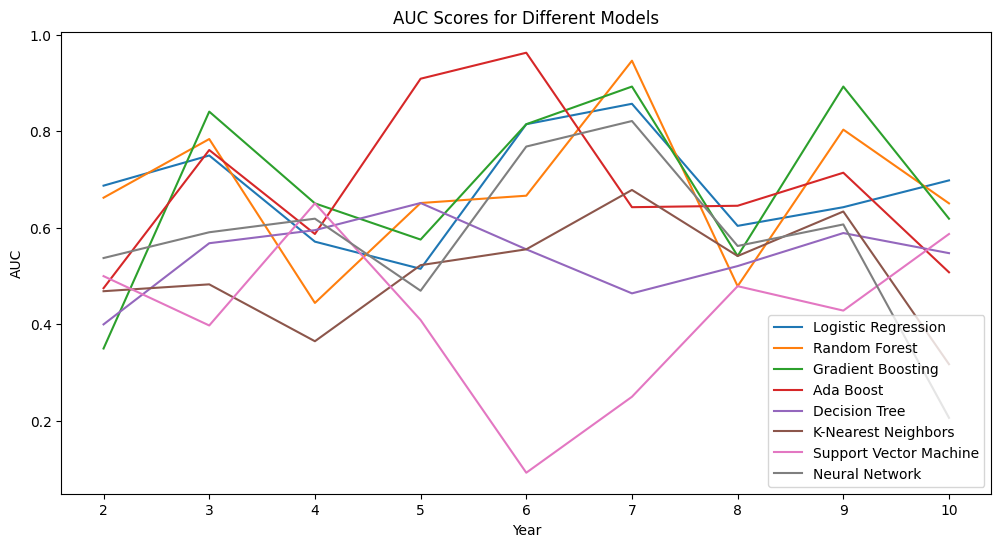

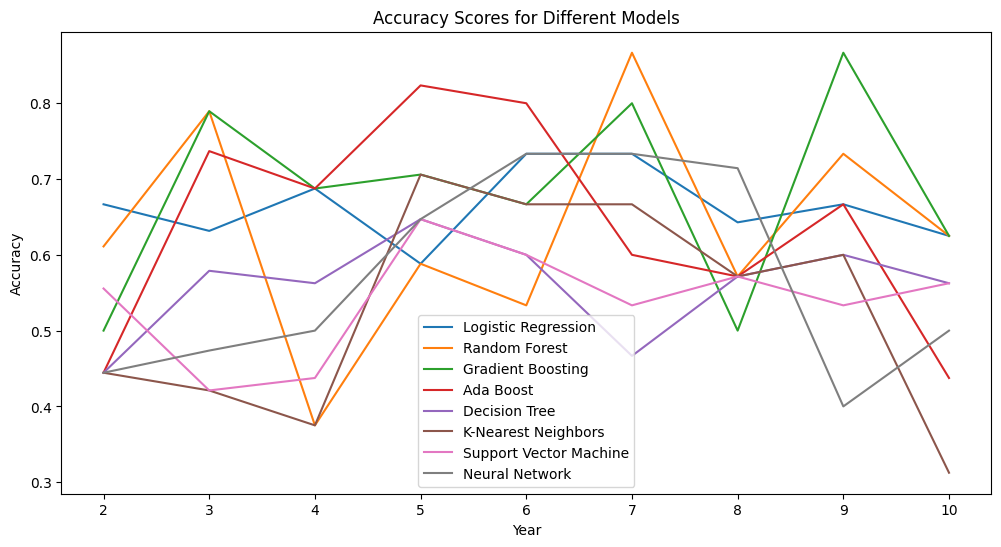

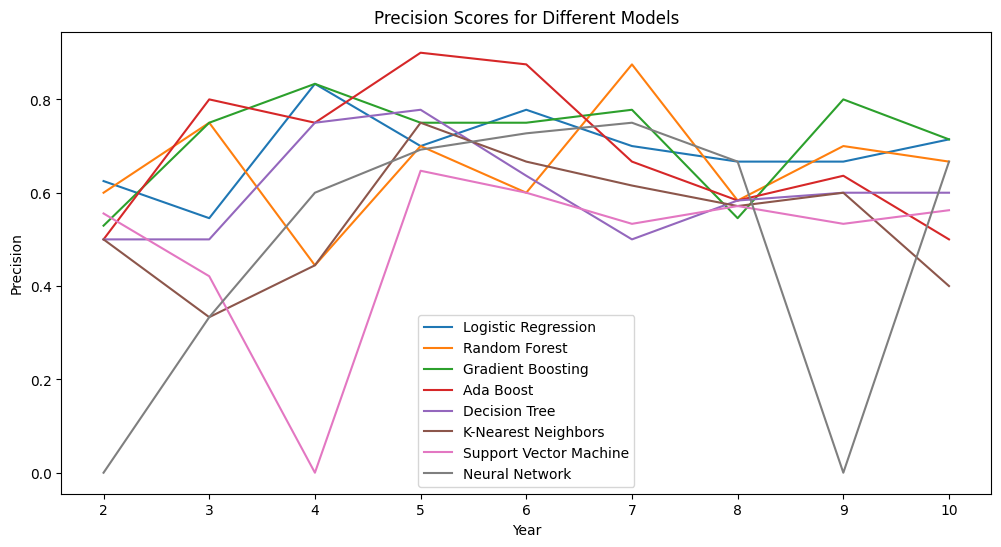

In [17]:
# Test various models and see which one performs the best
models = {
    "Logistic Regression": LogisticRegression(max_iter=10000),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Ada Boost": AdaBoostClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Support Vector Machine": SVC(probability=True),
    "Neural Network": MLPClassifier()
}

min_year = 2
max_year = 10

# Create a dictionary to store the AUC, accuracy and precision scores for each model
auc_scores = {}
accuracy_scores = {}
precision_scores = {}

for name, model in models.items():
    print(f"\nTraining model: {name}")
    auc_scores[name] = []
    accuracy_scores[name] = []
    precision_scores[name] = []

    for i in range(min_year, max_year + 1):
        new_df = create_predictions(df, i, model, distribution_similarity=False)
        auc_scores[name].append(roc_auc_score(new_df['playoff'], new_df['prediction_proba']))
        accuracy_scores[name].append(accuracy_score(new_df['playoff'], new_df['prediction']))
        precision_scores[name].append(precision_score(new_df['playoff'], new_df['prediction']))

# Plot the AUC scores for each model
plt.figure(figsize=(12, 6))

for name, scores in auc_scores.items():
    plt.plot(range(min_year, max_year + 1), scores, label=name)

plt.xlabel("Year")
plt.ylabel("AUC")
plt.title("AUC Scores for Different Models")
plt.legend()
plt.show()

# Plot the accuracy scores for each model
plt.figure(figsize=(12, 6))

for name, scores in accuracy_scores.items():
    plt.plot(range(min_year, max_year + 1), scores, label=name)

plt.xlabel("Year")
plt.ylabel("Accuracy")
plt.title("Accuracy Scores for Different Models")
plt.legend()
plt.show()

# Plot the precision scores for each model
plt.figure(figsize=(12, 6))

for name, scores in precision_scores.items():
    plt.plot(range(min_year, max_year + 1), scores, label=name)

plt.xlabel("Year")
plt.ylabel("Precision")
plt.title("Precision Scores for Different Models")
plt.legend()
plt.show()

In [18]:
# Create predictions for the best model
best_model = GradientBoostingClassifier() # An example of the best model

def create_final_predictions(df, year):
    # Select the best 4 teams for each conference (confID) ensuring unique teams
    final_predictions = df[df['year'] == year].sort_values(by='prediction_proba', ascending=False).drop_duplicates(subset='tmID').groupby('confID').head(4)

    # remove confID column
    final_predictions.drop(['year', 'playoff', 'confID'], axis=1, inplace=True)

    return final_predictions

# Add the tmID mapping to the final predictions so the final predictions have the team names
def convert_tmID_to_team(df, tmID_mapping):
    # Create a reverse mapping from the encoded numbers to the team names
    reverse_mapping = {v: k for k, v in tmID_mapping.items()}
    # Map the encoded tmID to the team names
    df['tmID'] = df['tmID'].map(reverse_mapping)
    return df

# Usage of the function within the loop
for i in range(min_year, max_year + 1):
    new_df = create_predictions(df, i, best_model, distribution_similarity=False)
    new_df = create_final_predictions(new_df, i)
    new_df.drop(new_df.columns.difference(['tmID', 'confID', 'year', 'playoff', 'prediction', 'prediction_proba']), axis=1, inplace=True)
    new_df = convert_tmID_to_team(new_df, tmID_mapping)
    new_df.to_csv(f"../data/predictions/predictions_{i}.csv", index=False)


Train/Test size for year=2: (17, 60) (18, 60) (17,) (18,)

Train/Test size for year=3: (35, 60) (19, 60) (35,) (19,)

Train/Test size for year=4: (54, 60) (16, 60) (54,) (16,)

Train/Test size for year=5: (70, 60) (17, 60) (70,) (17,)

Train/Test size for year=6: (87, 60) (15, 60) (87,) (15,)

Train/Test size for year=7: (102, 60) (15, 60) (102,) (15,)

Train/Test size for year=8: (117, 60) (14, 60) (117,) (14,)

Train/Test size for year=9: (131, 60) (15, 60) (131,) (15,)

Train/Test size for year=10: (146, 60) (16, 60) (146,) (16,)


## Overfitting analyses

We train the models on different sets of data to predict which teams are going to make it to the playoffs

We start with year 10 since it's the year that can take the most data and we can test.

To test is on year 10, we train the models first only using 2 years, 8 and 9. We increase this range of years by one, train and test the models to obtain a graph depicting the performance of the models when making predictions for year 10 for different ranges of years used to train the models.


Training model: Logistic Regression

Train/Test size for year=10: (44, 60) (16, 60) (44,) (16,)

Train/Test size for year=10: (59, 60) (16, 60) (59,) (16,)

Train/Test size for year=10: (76, 60) (16, 60) (76,) (16,)

Train/Test size for year=10: (92, 60) (16, 60) (92,) (16,)


C:\Users\marco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\marco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stab


Train/Test size for year=10: (111, 60) (16, 60) (111,) (16,)

Train/Test size for year=10: (129, 60) (16, 60) (129,) (16,)

Train/Test size for year=10: (146, 60) (16, 60) (146,) (16,)

Training model: Random Forest

Train/Test size for year=10: (44, 60) (16, 60) (44,) (16,)


C:\Users\marco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\marco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stab


Train/Test size for year=10: (59, 60) (16, 60) (59,) (16,)

Train/Test size for year=10: (76, 60) (16, 60) (76,) (16,)

Train/Test size for year=10: (92, 60) (16, 60) (92,) (16,)

Train/Test size for year=10: (111, 60) (16, 60) (111,) (16,)

Train/Test size for year=10: (129, 60) (16, 60) (129,) (16,)

Train/Test size for year=10: (146, 60) (16, 60) (146,) (16,)

Training model: Gradient Boosting

Train/Test size for year=10: (44, 60) (16, 60) (44,) (16,)

Train/Test size for year=10: (59, 60) (16, 60) (59,) (16,)

Train/Test size for year=10: (76, 60) (16, 60) (76,) (16,)

Train/Test size for year=10: (92, 60) (16, 60) (92,) (16,)

Train/Test size for year=10: (111, 60) (16, 60) (111,) (16,)

Train/Test size for year=10: (129, 60) (16, 60) (129,) (16,)

Train/Test size for year=10: (146, 60) (16, 60) (146,) (16,)

Training model: Ada Boost

Train/Test size for year=10: (44, 60) (16, 60) (44,) (16,)

Train/Test size for year=10: (59, 60) (16, 60) (59,) (16,)

Train/Test size for year=

C:\Users\marco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\marco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\marco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_p


Train/Test size for year=10: (76, 60) (16, 60) (76,) (16,)

Train/Test size for year=10: (92, 60) (16, 60) (92,) (16,)

Train/Test size for year=10: (111, 60) (16, 60) (111,) (16,)

Train/Test size for year=10: (129, 60) (16, 60) (129,) (16,)

Train/Test size for year=10: (146, 60) (16, 60) (146,) (16,)


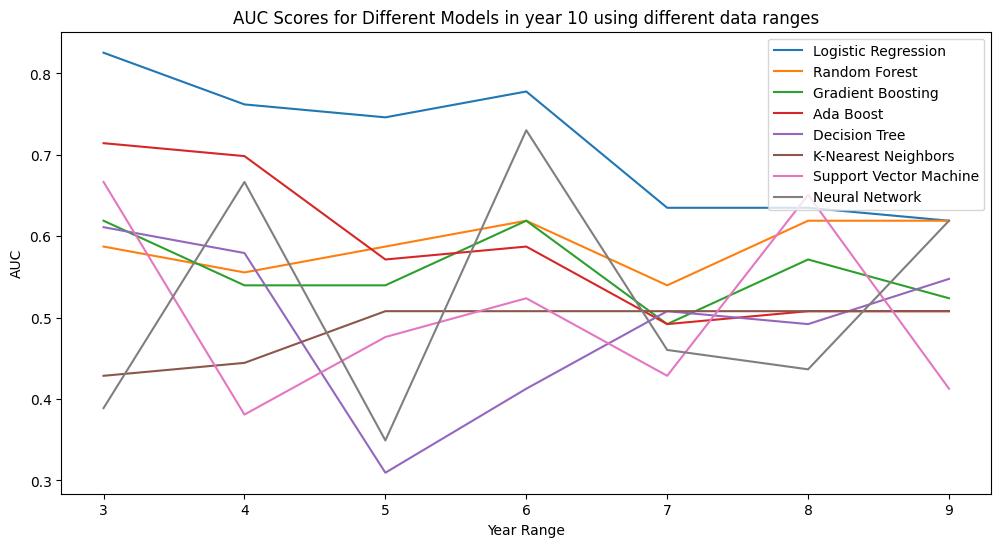

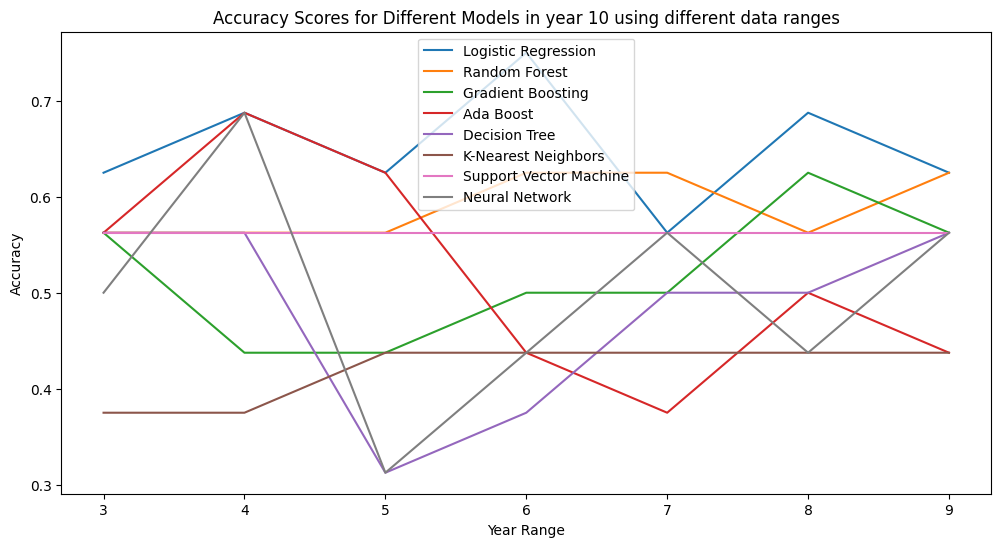

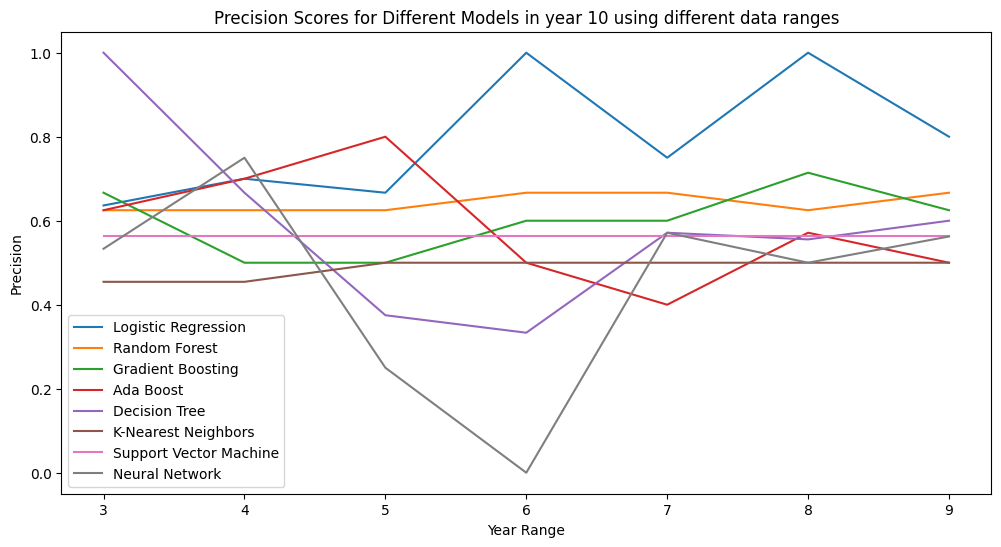

In [19]:
# Test various models and see which one performs the best
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=1000),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=1000, learning_rate=0.3),
    "Ada Boost": AdaBoostClassifier(),
    "Decision Tree": DecisionTreeClassifier(max_depth=10, min_samples_split=5),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=8, weights='distance'),
    "Support Vector Machine": SVC(probability=True),
    "Neural Network": MLPClassifier(solver='adam')
}

min_diff = 3 # we train using at least data from 2 years ago
max_diff = 9 # we train using at most data from 9 years ago

# Create a dictionary to store the AUC, accuracy and precision scores for each model
auc_scores = {}
accuracy_scores = {}
precision_scores = {}

for name, model in models.items():
    print(f"\nTraining model: {name}")
    auc_scores[name] = []
    accuracy_scores[name] = []
    precision_scores[name] = []

    for i in range(min_diff, max_diff + 1):
        # make predictions for year 10 using different amounts of data ( 2 to 10 years ago)
        new_df = create_predictions(df, 10, model, maximum_diff=i,distribution_similarity=False) 
        auc_scores[name].append(roc_auc_score(new_df['playoff'], new_df['prediction_proba']))
        accuracy_scores[name].append(accuracy_score(new_df['playoff'], new_df['prediction']))
        precision_scores[name].append(precision_score(new_df['playoff'], new_df['prediction']))

# Plot the AUC scores for each model
plt.figure(figsize=(12, 6))

for name, scores in auc_scores.items():
    plt.plot(range(min_diff, max_diff + 1), scores, label=name)

plt.xlabel("Year Range")
plt.ylabel("AUC")
plt.title("AUC Scores for Different Models in year 10 using different data ranges")
plt.legend()
plt.show()

# Plot the accuracy scores for each model
plt.figure(figsize=(12, 6))

for name, scores in accuracy_scores.items():
    plt.plot(range(min_diff, max_diff + 1), scores, label=name)

plt.xlabel("Year Range")
plt.ylabel("Accuracy")
plt.title("Accuracy Scores for Different Models in year 10 using different data ranges")
plt.legend()
plt.show()

# Plot the precision scores for each model
plt.figure(figsize=(12, 6))

for name, scores in precision_scores.items():
    plt.plot(range(min_diff, max_diff + 1), scores, label=name)

plt.xlabel("Year Range")
plt.ylabel("Precision")
plt.title("Precision Scores for Different Models in year 10 using different data ranges")
plt.legend()
plt.show()

We see a decline in the overall performance starting from the sixth year. That indicates that using more than 6 years to train the models ends up affecting negatively the performace, generally speaking.

Let's see if the pattern is consistent for other years. 


Training model: Logistic Regression

Train/Test size for year=9: (44, 60) (15, 60) (44,) (15,)

Train/Test size for year=9: (61, 60) (15, 60) (61,) (15,)

Train/Test size for year=9: (77, 60) (15, 60) (77,) (15,)

Train/Test size for year=9: (96, 60) (15, 60) (96,) (15,)


C:\Users\marco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\marco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stab


Train/Test size for year=9: (114, 60) (15, 60) (114,) (15,)

Train/Test size for year=9: (131, 60) (15, 60) (131,) (15,)

Training model: Random Forest

Train/Test size for year=9: (44, 60) (15, 60) (44,) (15,)


C:\Users\marco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\marco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stab


Train/Test size for year=9: (61, 60) (15, 60) (61,) (15,)

Train/Test size for year=9: (77, 60) (15, 60) (77,) (15,)

Train/Test size for year=9: (96, 60) (15, 60) (96,) (15,)

Train/Test size for year=9: (114, 60) (15, 60) (114,) (15,)

Train/Test size for year=9: (131, 60) (15, 60) (131,) (15,)

Training model: Gradient Boosting

Train/Test size for year=9: (44, 60) (15, 60) (44,) (15,)

Train/Test size for year=9: (61, 60) (15, 60) (61,) (15,)

Train/Test size for year=9: (77, 60) (15, 60) (77,) (15,)

Train/Test size for year=9: (96, 60) (15, 60) (96,) (15,)

Train/Test size for year=9: (114, 60) (15, 60) (114,) (15,)

Train/Test size for year=9: (131, 60) (15, 60) (131,) (15,)

Training model: Ada Boost

Train/Test size for year=9: (44, 60) (15, 60) (44,) (15,)

Train/Test size for year=9: (61, 60) (15, 60) (61,) (15,)

Train/Test size for year=9: (77, 60) (15, 60) (77,) (15,)

Train/Test size for year=9: (96, 60) (15, 60) (96,) (15,)

Train/Test size for year=9: (114, 60) (15, 6

C:\Users\marco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\marco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



Train/Test size for year=9: (77, 60) (15, 60) (77,) (15,)

Train/Test size for year=9: (96, 60) (15, 60) (96,) (15,)


C:\Users\marco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\marco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



Train/Test size for year=9: (114, 60) (15, 60) (114,) (15,)

Train/Test size for year=9: (131, 60) (15, 60) (131,) (15,)


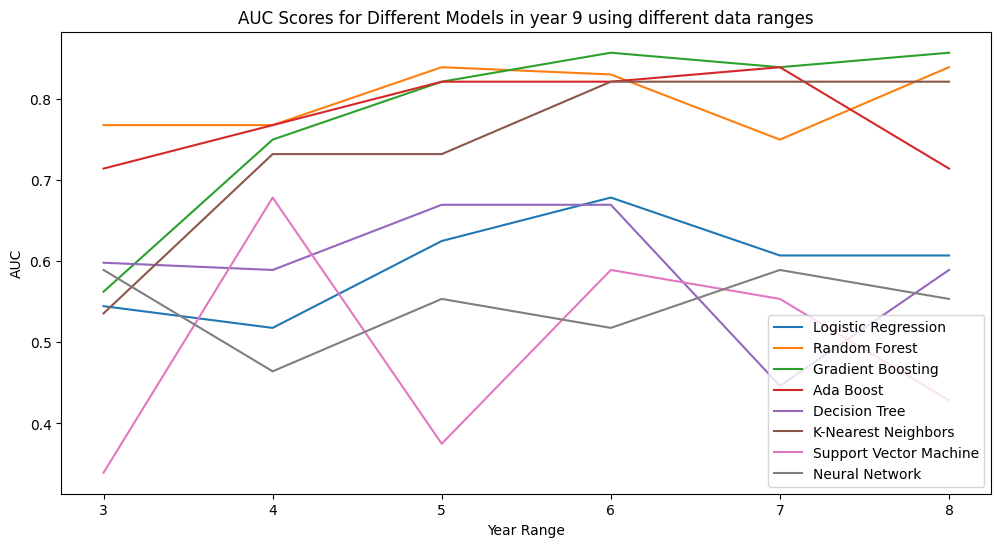

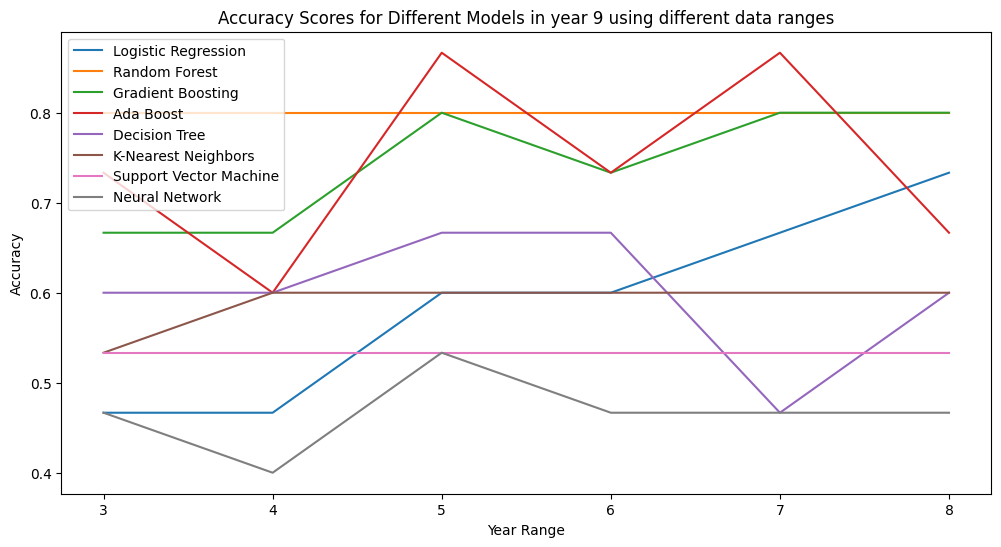

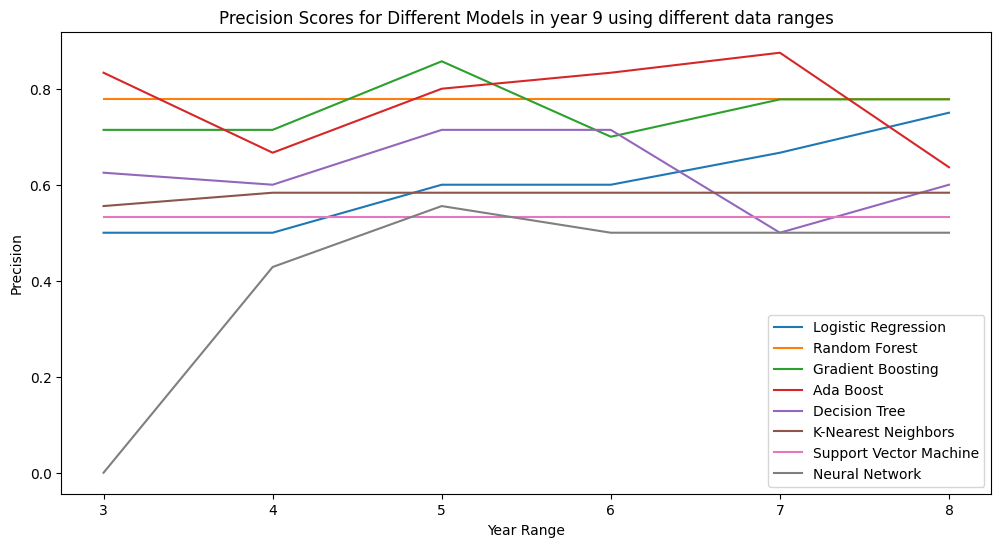

In [20]:
# Test various models and see which one performs the best
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=1000),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=1000, learning_rate=0.3),
    "Ada Boost": AdaBoostClassifier(),
    "Decision Tree": DecisionTreeClassifier(max_depth=10, min_samples_split=5),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=8, weights='distance'),
    "Support Vector Machine": SVC(probability=True),
    "Neural Network": MLPClassifier(solver='adam')
}

min_diff = 3 # we train using at least data from 2 years ago
max_diff = 8 # we train using at most data from 9 years ago

# Create a dictionary to store the AUC, accuracy and precision scores for each model
auc_scores = {}
accuracy_scores = {}
precision_scores = {}

for name, model in models.items():
    print(f"\nTraining model: {name}")
    auc_scores[name] = []
    accuracy_scores[name] = []
    precision_scores[name] = []

    for i in range(min_diff, max_diff + 1):
        # make predictions for year 10 using different amounts of data ( 2 to 10 years ago)
        new_df = create_predictions(df, 9, model, maximum_diff=i,distribution_similarity=False) 
        auc_scores[name].append(roc_auc_score(new_df['playoff'], new_df['prediction_proba']))
        accuracy_scores[name].append(accuracy_score(new_df['playoff'], new_df['prediction']))
        precision_scores[name].append(precision_score(new_df['playoff'], new_df['prediction']))

# Plot the AUC scores for each model
plt.figure(figsize=(12, 6))

for name, scores in auc_scores.items():
    plt.plot(range(min_diff, max_diff + 1), scores, label=name)

plt.xlabel("Year Range")
plt.ylabel("AUC")
plt.title("AUC Scores for Different Models in year 9 using different data ranges")
plt.legend()
plt.show()

# Plot the accuracy scores for each model
plt.figure(figsize=(12, 6))

for name, scores in accuracy_scores.items():
    plt.plot(range(min_diff, max_diff + 1), scores, label=name)

plt.xlabel("Year Range")
plt.ylabel("Accuracy")
plt.title("Accuracy Scores for Different Models in year 9 using different data ranges")
plt.legend()
plt.show()

# Plot the precision scores for each model
plt.figure(figsize=(12, 6))

for name, scores in precision_scores.items():
    plt.plot(range(min_diff, max_diff + 1), scores, label=name)

plt.xlabel("Year Range")
plt.ylabel("Precision")
plt.title("Precision Scores for Different Models in year 9 using different data ranges")
plt.legend()
plt.show()


Training model: Logistic Regression

Train/Test size for year=8: (47, 60) (14, 60) (47,) (14,)

Train/Test size for year=8: (63, 60) (14, 60) (63,) (14,)

Train/Test size for year=8: (82, 60) (14, 60) (82,) (14,)

Train/Test size for year=8: (100, 60) (14, 60) (100,) (14,)


C:\Users\marco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\marco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stab


Train/Test size for year=8: (117, 60) (14, 60) (117,) (14,)

Training model: Random Forest

Train/Test size for year=8: (47, 60) (14, 60) (47,) (14,)

Train/Test size for year=8: (63, 60) (14, 60) (63,) (14,)

Train/Test size for year=8: (82, 60) (14, 60) (82,) (14,)

Train/Test size for year=8: (100, 60) (14, 60) (100,) (14,)

Train/Test size for year=8: (117, 60) (14, 60) (117,) (14,)

Training model: Gradient Boosting

Train/Test size for year=8: (47, 60) (14, 60) (47,) (14,)

Train/Test size for year=8: (63, 60) (14, 60) (63,) (14,)

Train/Test size for year=8: (82, 60) (14, 60) (82,) (14,)

Train/Test size for year=8: (100, 60) (14, 60) (100,) (14,)

Train/Test size for year=8: (117, 60) (14, 60) (117,) (14,)

Training model: Ada Boost

Train/Test size for year=8: (47, 60) (14, 60) (47,) (14,)

Train/Test size for year=8: (63, 60) (14, 60) (63,) (14,)

Train/Test size for year=8: (82, 60) (14, 60) (82,) (14,)

Train/Test size for year=8: (100, 60) (14, 60) (100,) (14,)

Train/Tes

C:\Users\marco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



Train/Test size for year=8: (117, 60) (14, 60) (117,) (14,)


C:\Users\marco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


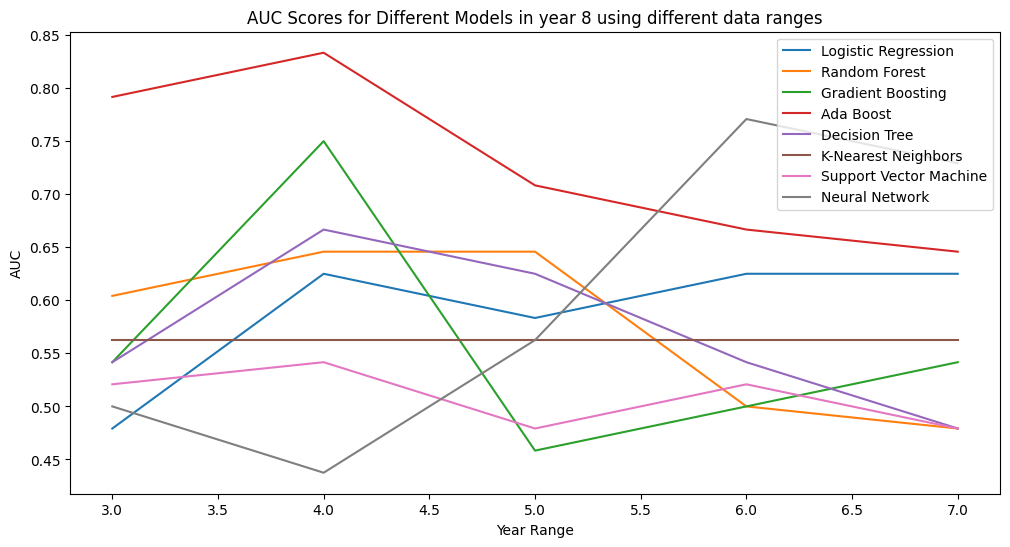

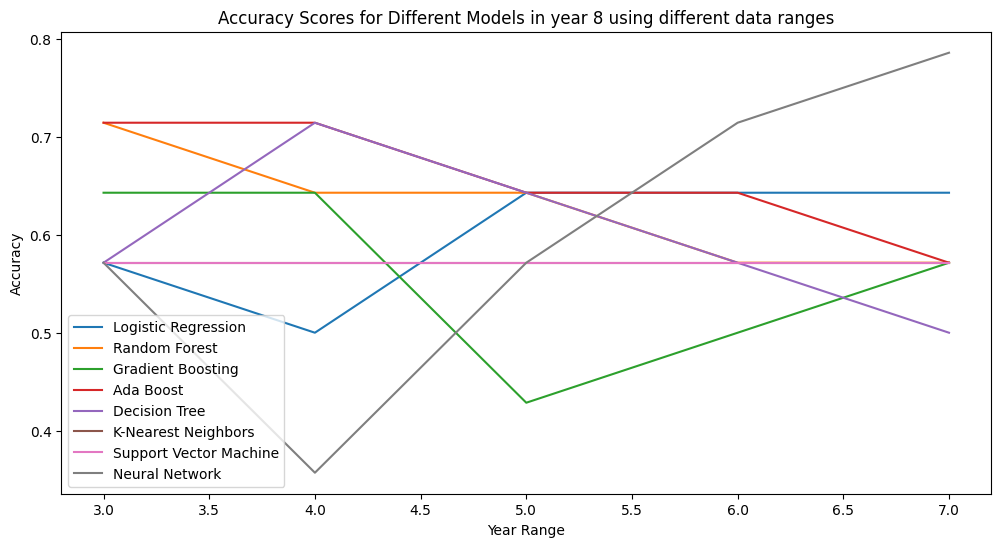

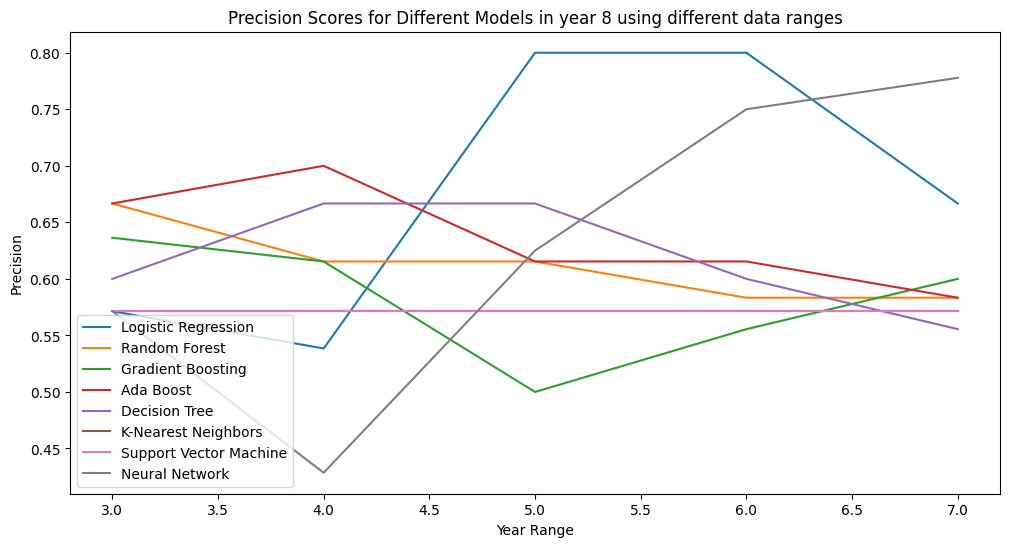

In [21]:
# Test various models and see which one performs the best
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=1000),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=1000, learning_rate=0.3),
    "Ada Boost": AdaBoostClassifier(),
    "Decision Tree": DecisionTreeClassifier(max_depth=10, min_samples_split=5),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=8, weights='distance'),
    "Support Vector Machine": SVC(probability=True),
    "Neural Network": MLPClassifier(solver='adam')
}

min_diff = 3 # we train using at least data from 2 years ago
max_diff = 7 # we train using at most data from 9 years ago

# Create a dictionary to store the AUC, accuracy and precision scores for each model
auc_scores = {}
accuracy_scores = {}
precision_scores = {}

for name, model in models.items():
    print(f"\nTraining model: {name}")
    auc_scores[name] = []
    accuracy_scores[name] = []
    precision_scores[name] = []

    for i in range(min_diff, max_diff + 1):
        # make predictions for year 10 using different amounts of data ( 2 to 10 years ago)
        new_df = create_predictions(df, 8, model, maximum_diff=i,distribution_similarity=False) 
        auc_scores[name].append(roc_auc_score(new_df['playoff'], new_df['prediction_proba']))
        accuracy_scores[name].append(accuracy_score(new_df['playoff'], new_df['prediction']))
        precision_scores[name].append(precision_score(new_df['playoff'], new_df['prediction']))

# Plot the AUC scores for each model
plt.figure(figsize=(12, 6))

for name, scores in auc_scores.items():
    plt.plot(range(min_diff, max_diff + 1), scores, label=name)

plt.xlabel("Year Range")
plt.ylabel("AUC")
plt.title("AUC Scores for Different Models in year 8 using different data ranges")
plt.legend()
plt.show()

# Plot the accuracy scores for each model
plt.figure(figsize=(12, 6))

for name, scores in accuracy_scores.items():
    plt.plot(range(min_diff, max_diff + 1), scores, label=name)

plt.xlabel("Year Range")
plt.ylabel("Accuracy")
plt.title("Accuracy Scores for Different Models in year 8 using different data ranges")
plt.legend()
plt.show()

# Plot the precision scores for each model
plt.figure(figsize=(12, 6))

for name, scores in precision_scores.items():
    plt.plot(range(min_diff, max_diff + 1), scores, label=name)

plt.xlabel("Year Range")
plt.ylabel("Precision")
plt.title("Precision Scores for Different Models in year 8 using different data ranges")
plt.legend()
plt.show()